# <center>  Deep Neural Network (DNN) using plain TensorFlow

### Regularization of DNN [256,256,256,256] with max-norm regularization

## <font color = 'blue'> Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time
from functools import partial

%store -r
%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.7957011
X_32train_std             -> array([[-0.44445615,  0.62874736, -0.19049071, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[-0.004097
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.8784659
X_train                   -> array([[[-0.00304779,  0.0030504 , -0.00249425, ..
X_train_std               -> array([[-0.44445615,  0.62874736, -0.19049071, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {0: array([6, 7, 1, ..
y_32_train                -> array([7, 2, 4, ..., 5, 5, 3])
y_test                    -> defaultdict(<class 'list'>, {0: array([3, 2, 5, ..
y_train                   -> array([7, 2, 4, ..., 5, 5, 3])


In [2]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

Training data:  (80000, 32) and labels:  (80000,)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
# tf.reset_default_graph()

## <font color='blue'> Create validation set required for early stopping

In [4]:
X_val = []
y_val = []

X_test_new = defaultdict(list)
y_test_new = defaultdict(list)

for snr in snrs:
    n_test = X_32test_std[snr].shape[0]
    X_val.append(X_32test_std[snr][:(n_test*0.5)])
    y_val.append(y_32_test[snr][:(n_test*0.5)])
    X_test_new[snr] = X_32test_std[snr][(n_test*0.5):]
    y_test_new[snr] = y_32_test[snr][(n_test*0.5):]
    
X_val = np.vstack(np.asarray(X_val))
y_val =np.hstack(np.asarray(y_val))

print("Validation set data", X_val.shape, "and labels", y_val.shape)

X_32test_std = X_test_new
y_32_test = y_test_new
X_32_val = X_val 
y_32_val = y_val

Validation set data (40000, 32) and labels (40000,)


## <font color = 'blue'> Design and train the DNN

In [5]:
# ----------------- Initialize parameters -----------------------


n_hidden1 = 256
n_hidden2 = 256
n_hidden3 = 256
n_hidden4 = 256

n_outputs = 8

X = tf.placeholder(tf.float32, shape=(None, 32))
y = tf.placeholder(tf.int64, shape=(None))
training_ = tf.placeholder_with_default(False, shape=[])

weight_init = tf.contrib.layers.xavier_initializer()
activation_func = tf.nn.elu

max_clip_value = 1.0

# ------------------- Define layers -----------------------

def dense_layer(input_layer, n_neurons, kernel_init, activation, name):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init, name = name)
    return fully_conn
        
dense_layer1 = dense_layer(X, n_hidden1, weight_init, activation_func, "dense1")

dl1_weights = tf.get_default_graph().get_tensor_by_name("dense1/kernel:0")
clipped1 = tf.clip_by_norm(dl1_weights, clip_norm = max_clip_value, axes=1)
dl1_clipped = tf.assign(dl1_weights, clipped1)

dense_layer2 = dense_layer(dense_layer1, n_hidden2, weight_init, activation_func, "dense2")

dl2_weights = tf.get_default_graph().get_tensor_by_name("dense2/kernel:0")
clipped2 = tf.clip_by_norm(dl2_weights, clip_norm = max_clip_value, axes=1)
dl2_clipped = tf.assign(dl2_weights, clipped2)

dense_layer3 = dense_layer(dense_layer2, n_hidden3, weight_init, activation_func, "dense3")

dl3_weights = tf.get_default_graph().get_tensor_by_name("dense3/kernel:0")
clipped3 = tf.clip_by_norm(dl3_weights, clip_norm = max_clip_value, axes=1)
dl3_clipped = tf.assign(dl3_weights, clipped3)

dense_layer4 = dense_layer(dense_layer3, n_hidden4, weight_init, activation_func, "dense4")

dl4_weights = tf.get_default_graph().get_tensor_by_name("dense4/kernel:0")
clipped4 = tf.clip_by_norm(dl4_weights, clip_norm = max_clip_value, axes=1)
dl4_clipped = tf.assign(dl4_weights, clipped4)

logits = tf.layers.dense(dense_layer4, n_outputs)
softmax_activations = tf.nn.softmax(logits)

# ----------------- Specify performance measure ----------------------

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
# ------------------ Execution phase ----------------------------------    

n_epochs = 1000
batch_size = 1024
n_train = X_train_std.shape[0]
n_iter = n_train//batch_size

saver = tf.train.Saver()

min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

acc_test = defaultdict(list)

start = time()
path = "./DNN4layer_regtech_maxnorm"

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size) #select random samples to form mini batches   
            X_batch, y_batch = X_32train_std[rand_indices], y_32_train[rand_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch,  training_: True})
        valid_loss, acc_val = sess.run([loss, accuracy], feed_dict={X: X_32_val, y: y_32_val, training_: True})
        
        # Early stopping 
        
        if valid_loss < min_loss:
            save_path = saver.save(sess, path)
            min_loss = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > max_epochs_without_improvement:
                print("** EARLY STOPPING ** ")
                break
        print("{}\tValidation loss: {:.6f}\tMinimum loss: {:.6f}\tAccuracy on validation set: {:.2f}".format(
            epoch, valid_loss, min_loss, acc_val))

print(" ")
with tf.Session() as sess:
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_32test_std[snr], y: y_32_test[snr]})

print("Training and testing took %f minutes"%(float(time() - start)/60))

0	Validation loss: 1.398042	Minimum loss: 1.398042	Accuracy on validation set: 0.42
1	Validation loss: 1.319292	Minimum loss: 1.319292	Accuracy on validation set: 0.45
2	Validation loss: 1.308735	Minimum loss: 1.308735	Accuracy on validation set: 0.46
3	Validation loss: 1.284621	Minimum loss: 1.284621	Accuracy on validation set: 0.47
4	Validation loss: 1.243694	Minimum loss: 1.243694	Accuracy on validation set: 0.49
5	Validation loss: 1.230867	Minimum loss: 1.230867	Accuracy on validation set: 0.49
6	Validation loss: 1.201689	Minimum loss: 1.201689	Accuracy on validation set: 0.50
7	Validation loss: 1.195004	Minimum loss: 1.195004	Accuracy on validation set: 0.50
8	Validation loss: 1.194342	Minimum loss: 1.194342	Accuracy on validation set: 0.50
9	Validation loss: 1.191829	Minimum loss: 1.191829	Accuracy on validation set: 0.50
10	Validation loss: 1.185067	Minimum loss: 1.185067	Accuracy on validation set: 0.50
11	Validation loss: 1.181152	Minimum loss: 1.181152	Accuracy on validation 

## <font color = 'blue'> Test the DNN

In [6]:
for snr in snrs:
    print("DNN's test accuracy on %d dB SNR samples = "%(snr), acc_test[snr])   

DNN's test accuracy on -20 dB SNR samples =  0.134
DNN's test accuracy on -18 dB SNR samples =  0.1365
DNN's test accuracy on -16 dB SNR samples =  0.129
DNN's test accuracy on -14 dB SNR samples =  0.1385
DNN's test accuracy on -12 dB SNR samples =  0.1275
DNN's test accuracy on -10 dB SNR samples =  0.191
DNN's test accuracy on -8 dB SNR samples =  0.2955
DNN's test accuracy on -6 dB SNR samples =  0.369
DNN's test accuracy on -4 dB SNR samples =  0.407
DNN's test accuracy on -2 dB SNR samples =  0.482
DNN's test accuracy on 0 dB SNR samples =  0.586
DNN's test accuracy on 2 dB SNR samples =  0.7015
DNN's test accuracy on 4 dB SNR samples =  0.812
DNN's test accuracy on 6 dB SNR samples =  0.828
DNN's test accuracy on 8 dB SNR samples =  0.838
DNN's test accuracy on 10 dB SNR samples =  0.828
DNN's test accuracy on 12 dB SNR samples =  0.834
DNN's test accuracy on 14 dB SNR samples =  0.833
DNN's test accuracy on 16 dB SNR samples =  0.834
DNN's test accuracy on 18 dB SNR samples =  

## <font color = 'blue'> Visualize DNN's performance

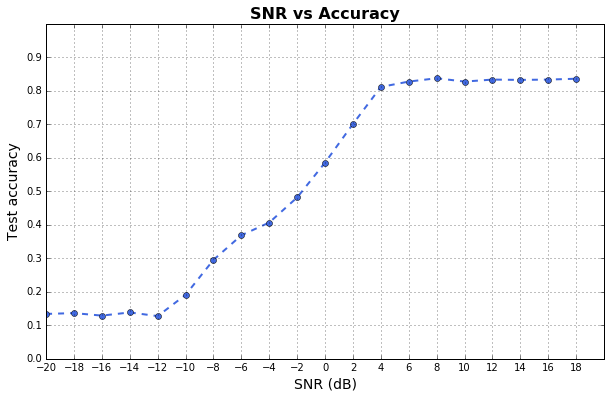

In [7]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./DNN4layer_regtech_maxnorm
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.81  0.00   0.00  0.00  0.00   0.08   0.10  0.00
BPSK   0.00  1.00   0.00  0.00  0.00   0.00   0.00  0.00
CPFSK  0.01  0.00   0.97  0.00  0.00   0.01   0.02  0.00
GFSK   0.02  0.00   0.01  0.96  0.00   0.00   0.01  0.00
PAM4   0.00  0.01   0.00  0.00  0.98   0.00   0.01  0.00
QAM16  0.02  0.00   0.00  0.00  0.00   0.45   0.52  0.00
QAM64  0.02  0.00   0.00  0.00  0.00   0.49   0.49  0.00
QPSK   0.03  0.01   0.00  0.00  0.01   0.05   0.02  0.88


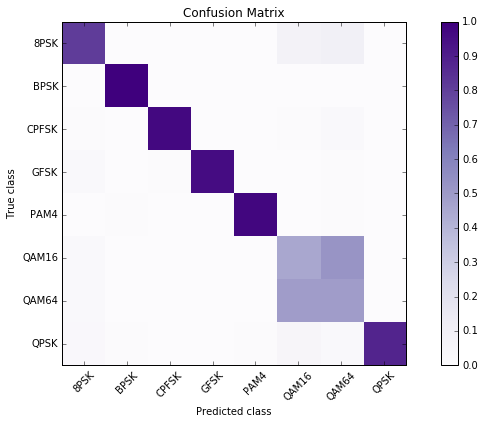

In [8]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_32test_std[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_32_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()